# Coursea Capstone 2021 
<b> SINGAPORE : a global city of opportunity

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Libraries](#libraries)
* [Methodology](#methodology)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for people who are moving to Singapore or for Singaporeans who simply want to know better their neighborhood.

We are then particularly interested in **residential areas with lots of accessibility to different type of venues**. We will also provide insights such as **housing prices and schools**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen about which area and neighborhood to choose when moving to this new city.

## Libraries <a name="libraries"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import json
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import glob
from functools import reduce

## Methodology <a name="methodology"></a>

### Data exploration, geocoding and wrangling

Following data sources will be needed to extract/generate the required information:
* Postal districts from **Wikipedia** with latitude and longitute data obtained with python geocode package
* Private schools data obtained from https://data.gov.sg/ as a geojon file
* Private residential sales prices obtained from www.ura.gov.sg by postal district
* Different venue type and their location in every neighborhood will be obtained using **Foursquare API**

After gathering and selecting, the data is transform to answer the business problem

### Data visualization

The different neighbourhoods are then visualize in a map using the folium package. 


### Data analysis

As there is no labelled data available, an **unsupervised learning model** will be used for this project and the technique is by **K-means clustering**. K-means clustering will form clusters and find groups within the data. K-means clustering groups data points that are close together and at the same time, maximise the inter clusters’ distance. 

After which, we can start to derive certain assumptions from those clusters. In order to perform clustering, numerical data is required and one-hot encoding is used to change our data variables to numerical ones. 
Once done, we can perform clustering and visualize the clusters in the map below.


## Data <a name="data"></a>

### Scap data from wikipedia

In [2]:
url = "https://en.wikipedia.org/wiki/Postal_codes_in_Singapore#Postal_districts"
Postal_districts = pd.read_html(url, header=0)[0]
Postal_districts.rename(columns={'Postal sector(1st 2 digits of 6-digit postal codes)':'Postal Code'}, inplace=True)
Postal_districts.head()

,Postal district,Postal Code,General location
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,2,"07, 08","Anson, Tanjong Pagar"
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,4,"09, 10","Telok Blangah, Harbourfront"
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


#### Find the latitude and longitude of each location

In [3]:
#Define a get coordinates function
def get_latlng(general_l):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Singapore'.format(general_l))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [4]:
#call the function and store to a list
coords = [ get_latlng(general_l) for general_l in Postal_districts["General location"].tolist() ]

In [5]:
coords[0:5]

[[1.2818900000000326, 103.84912000000008],
 [1.2788900000000467, 103.84539000000007],
 [1.2930476624951979, 103.80624825312117],
 [1.2653312143819655, 103.81886147149507],
 [1.3147297600818462, 103.75679879624249]]

In [6]:
#Change the list to a dataframe
latlong_Postal_districts = pd.DataFrame(coords, columns= ['Latitude','Longitude'])
print(latlong_Postal_districts.shape)
latlong_Postal_districts.head()

(28, 2)


,Latitude,Longitude
0,1.281890,103.849120
1,1.278890,103.845390
2,1.293048,103.806248
3,1.265331,103.818861
4,1.314730,103.756799


In [7]:
Postal_districts['Latitude']= latlong_Postal_districts['Latitude']
Postal_districts['Longitude']= latlong_Postal_districts['Longitude']
# df.rename(columns={"Postal district": "Postal_district","General location":"General_location"}, inplace= True)
Postal_districts.head()

,Postal district,Postal Code,General location,Latitude,Longitude
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.281890,103.849120
1,2,"07, 08","Anson, Tanjong Pagar",1.278890,103.845390
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.293048,103.806248
3,4,"09, 10","Telok Blangah, Harbourfront",1.265331,103.818861
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.314730,103.756799


### Private schools data (geojson file)

In [8]:
with open ('private-education-institutions-geojson.geojson') as f:
    json_data = json.load(f)

In [9]:
private_schools_data = json_data['features']
private_schools_data[0]

{'type': 'Feature',
 'properties': {'Name': 'kml_1',
  'Description': '<center><table><tr><th colspan=\'2\' align=\'center\'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>HOUSE_NUMBER</th> <td>2</td> </tr><tr bgcolor=""> <th>HYPERLINK</th> <td>http://www.middleton.edu.sg/</td> </tr><tr bgcolor="#E3E3F3"> <th>BUILDING_NAME</th> <td></td> </tr><tr bgcolor=""> <th>LEVEL_NO</th> <td></td> </tr><tr bgcolor="#E3E3F3"> <th>STREETNAME</th> <td>TAMPINES STREET 92</td> </tr><tr bgcolor=""> <th>POSTALCODE</th> <td>528889</td> </tr><tr bgcolor="#E3E3F3"> <th>NAME_OF_SCHOOL</th> <td>MIDDLETON INTERNATIONAL SCHOOL</td> </tr><tr bgcolor=""> <th>UNIT_NO</th> <td></td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>6B7F7CEC466ACB00</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20190617082532</td> </tr><tr bgcolor="#E3E3F3"> <th>DESCRIPTION</th> <td>Private Education Institutions</td> </tr></table></center>'},
 'geometry': {'type': 'Point',
  'coordinates': [103.942461175191, 1.342664524

In [10]:
column_names = ['Name', 'Postal Code', 'Latitude', 'Longitude', 'Postal district'] 
private_schools = pd.DataFrame(columns=column_names)
private_schools

,Name,Postal Code,Latitude,Longitude,Postal district


In [11]:
for data in private_schools_data :
    private_school_latlon = data['geometry']['coordinates']
    private_school_lat = private_school_latlon[1]
    private_school_lon = private_school_latlon[0]
    private_schools = private_schools.append({'Latitude': private_school_lat,
                                          'Longitude': private_school_lon}, ignore_index=True)
private_schools.head(2)

,Name,Postal Code,Latitude,Longitude,Postal district
0,NaN,NaN,1.342665,103.942461,NaN
1,NaN,NaN,1.274508,103.845710,NaN


In [12]:
private_schools_data = pd.json_normalize(private_schools_data)
private_schools_data.head(2)

,type,properties.Name,properties.Description,geometry.type,geometry.coordinates
0,Feature,kml_1,<center><table><tr><th colspan='2' align='cent...,Point,"[103.942461175191, 1.34266452430936, 0.0]"
1,Feature,kml_2,<center><table><tr><th colspan='2' align='cent...,Point,"[103.8457102267, 1.27450787149749, 0.0]"


In [13]:
name_of_school = [0]*len(private_schools_data)

In [14]:
for i in range(len(private_schools_data)):
    j = 0
    x = pd.read_html(private_schools_data['properties.Description'][i])
    temp = x[0]
    name_of_school[i] = temp.iloc[6,1]

name_of_school
private_schools['Name'] = name_of_school 
private_schools.head()

,Name,Postal Code,Latitude,Longitude,Postal district
0,MIDDLETON INTERNATIONAL SCHOOL,NaN,1.342665,103.942461,NaN
1,IMPART LEARNING CENTRE,NaN,1.274508,103.845710,NaN
2,MIRROR D INTERNATIONAL COLLEGE,NaN,1.281197,103.843437,NaN
3,MMI ACADEMY,NaN,1.287049,103.847878,NaN
4,NANYANG ACADEMY,NaN,1.343321,103.775854,NaN


In [15]:
Postal_districts.head()

,Postal district,Postal Code,General location,Latitude,Longitude
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.281890,103.849120
1,2,"07, 08","Anson, Tanjong Pagar",1.278890,103.845390
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.293048,103.806248
3,4,"09, 10","Telok Blangah, Harbourfront",1.265331,103.818861
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.314730,103.756799


#### Match latitude and longitude of each postal district

In [16]:
postal_rows = range(len(Postal_districts))
school_rows = range(len(private_schools))

for w in school_rows:
    step_lat = private_schools['Latitude'].std()
    step_lon = private_schools['Longitude'].std()
    
    lat = private_schools.iloc[w,2]
    max_lat = lat + step_lat/2
    min_lat = lat - step_lat/2
    
    lon = private_schools.iloc[w,3]
    max_lon = lon + step_lon/2
    min_lon = lon - step_lon/2
    for r in postal_rows:
        if (min_lat <= Postal_districts.iloc[r,3] <= max_lat) and (min_lon <= Postal_districts.iloc[r,4] <= max_lon):
            private_schools.iloc[w,4] = Postal_districts.iloc[r,0]            

In [17]:
private_schools.head()

,Name,Postal Code,Latitude,Longitude,Postal district
0,MIDDLETON INTERNATIONAL SCHOOL,NaN,1.342665,103.942461,NaN
1,IMPART LEARNING CENTRE,NaN,1.274508,103.845710,2.0
2,MIRROR D INTERNATIONAL COLLEGE,NaN,1.281197,103.843437,13.0
3,MMI ACADEMY,NaN,1.287049,103.847878,13.0
4,NANYANG ACADEMY,NaN,1.343321,103.775854,21.0


In [18]:
private_schools.dropna().head()

,Name,Postal Code,Latitude,Longitude,Postal district


In [19]:
df = private_schools.groupby(['Postal district']).nunique()
df = df['Name']
privates_schools_grouped =  pd.DataFrame(df)
privates_schools_grouped.rename(columns = {'Name' : 'Private schools'}, inplace = True)
privates_schools_grouped.head()
# privates_schools_grouped.rename(columns = {'Name' : 'Number of school'}, inplace = True)
# privates_schools_grouped

,Private schools
Postal district,
2.0,6
3.0,24
4.0,6
5.0,2
6.0,2


###  Residential prices data

In [20]:
path = "residential_data"
all_files = glob.glob(path + "/*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.drop(['S/N', 'No. of Units', 'Area (Sqm)', 'Unit Price ($psm)'], axis =1)
property_sales_prices = frame.sort_values(by = ['Postal District'], ignore_index = True)
property_sales_prices.rename(columns = {'Postal District' : 'Postal district'}, inplace = True)


In [21]:
property_sales_prices.head()

,Project Name,Street Name,Type,Postal district,Market Segment,Tenure,Type of Sale,Price ($),Nett Price ($),Type of Area,Floor Level,Date of Sale
0,V ON SHENTON,SHENTON WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,New Sale,3290240,-,Strata,46 to 50,Jul-19
1,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,New Sale,1858230,-,Strata,06 to 10,May-19
2,V ON SHENTON,SHENTON WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,New Sale,2130000,-,Strata,51 to 55,May-19
3,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,New Sale,1827540,-,Strata,11 to 15,May-19
4,MARINA ONE RESIDENCES,MARINA WAY,Apartment,1,CCR,99 yrs lease commencing from 2011,New Sale,2803000,-,Strata,06 to 10,Jul-19


In [22]:
property_sales_prices = property_sales_prices.groupby('Postal district').mean()
property_sales_prices.head()

,Price ($)
Postal district,
1,3.648721e+06
2,1.802246e+06
3,1.547536e+06
4,1.627808e+06
5,1.299735e+06


### Put all the data into one dataframe

In [23]:
# sg_data = privates_schools_grouped.merge(Postal_districts, on = ['Postal district'], how = 'outer')
data_frames = [Postal_districts, privates_schools_grouped, property_sales_prices]
sg_data = reduce(lambda  left,right: pd.merge(left,right,on=['Postal district'], how='outer'), data_frames)

In [67]:
sg_data.sort_values(by = ['Postal district'], ignore_index = True).head()

,Postal district,Postal Code,General location,Latitude,Longitude,Private schools,Price ($)
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.281890,103.849120,NaN,3.648721e+06
1,2,"07, 08","Anson, Tanjong Pagar",1.278890,103.845390,6.0,1.802246e+06
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.293048,103.806248,24.0,1.547536e+06
3,4,"09, 10","Telok Blangah, Harbourfront",1.265331,103.818861,6.0,1.627808e+06
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.314730,103.756799,2.0,1.299735e+06


In [25]:
len(sg_data)

28

### Exploratory visualization

In [26]:
#Get geographical coordinates of Singapore 
address= 'Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


In [68]:
#Visualize the neighbourhoods in Singapore

#create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(sg_data['Latitude'], sg_data['Longitude'], sg_data['General location']):
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='coral',
        
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
map_sg

### Foursquare

Now that we have our location candidates, let's use Foursquare API to get info on the venues in each neighborhood.

In [28]:
#Define foursquare credentials and version

CLIENT_ID = 'LMPNBTTXPCFQSDJFXS0IJ4YH3HMZ1LREFCGVLW0Y0DCPGXT3' # your Foursquare ID
CLIENT_SECRET = 'RBTSAQ3JGTOEBGGNXIYRYOBVGX1BVFOBNXOFLSBJVRKZY3N2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LMPNBTTXPCFQSDJFXS0IJ4YH3HMZ1LREFCGVLW0Y0DCPGXT3
CLIENT_SECRET:RBTSAQ3JGTOEBGGNXIYRYOBVGX1BVFOBNXOFLSBJVRKZY3N2


Let's request the 200 venues in a 1000 meters radius around each neighbourhood

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
sg_venues = getNearbyVenues(names = sg_data['General location'],
                                   latitudes = sg_data['Latitude'],
                                   longitudes = sg_data['Longitude']
                                  )

In [31]:
sg_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Amoy Hotel,1.283118,103.848539,Hotel
1,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Luke's Oyster Bar & Chop House,1.282459,103.847240,Seafood Restaurant
2,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Napoleon Food & Wine Bar,1.279925,103.847333,Wine Bar
3,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Grain Traders,1.281468,103.850039,Restaurant
4,"Raffles Place, Cecil, Marina, People's Park",1.28189,103.84912,Lau Pa Sat Satay Street,1.280261,103.850235,Street Food Gathering


## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data.

In [32]:
sg_venues.groupby('Neighbourhood').count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Anson, Tanjong Pagar",100,100,100,100,100,100
"Ardmore, Bukit Timah, Holland Road, Tanglin",20,20,20,20,20,20
"Balestier, Toa Payoh, Serangoon",75,75,75,75,75,75
"Bedok, Upper East Coast, Eastwood, Kew Drive",33,33,33,33,33,33
"Bishan, Ang Mo Kio",27,27,27,27,27,27


In [33]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighbourhood'] = sg_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Neighbourhood,Airport,Airport Terminal,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Group venues base on the location in Singapore
sg_grouped = sg_onehot.groupby('Neighbourhood').mean().reset_index()
sg_grouped.head()

,Neighbourhood,Airport,Airport Terminal,American Restaurant,Aquarium,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,"Anson, Tanjong Pagar",0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.000000,0.020000,...,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.01,0.0
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.050000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0
2,"Balestier, Toa Payoh, Serangoon",0.0,0.0,0.026667,0.0,0.0,0.00,0.0,0.000000,0.053333,...,0.0,0.0,0.0,0.0,0.013333,0.0,0.0,0.0,0.00,0.0
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.030303,0.030303,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0
4,"Bishan, Ang Mo Kio",0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0


In [35]:
sg_grouped.shape

(28, 247)

### Most common venues near each neighborhood

In [36]:
#show the top 5 venues in each location 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
#Display the top 10 most common venues base on the location
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Neighbourhood'] = sg_grouped['Neighbourhood']

for ind in np.arange(sg_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

location_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Anson, Tanjong Pagar",Coffee Shop,Japanese Restaurant,Hotel,Italian Restaurant,Bakery,Cocktail Bar,Korean Restaurant,Ramen Restaurant,Seafood Restaurant,Spanish Restaurant
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",Bus Station,Playground,Café,Flower Shop,Bookstore,Garden,French Restaurant,Toy / Game Store,Shopping Mall,Bar
2,"Balestier, Toa Payoh, Serangoon",Coffee Shop,Chinese Restaurant,Asian Restaurant,Noodle House,Food Court,Park,Ice Cream Shop,Juice Bar,Sandwich Place,Fast Food Restaurant
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Bus Station,Coffee Shop,Bus Line,Food Court,School,Trail,Bus Stop,Campground,Other Great Outdoors,Supermarket
4,"Bishan, Ang Mo Kio",Chinese Restaurant,Soup Place,Food Court,Grocery Store,Thai Restaurant,General Entertainment,Park,Food & Drink Shop,Coffee Shop,Seafood Restaurant


### K-means clustering approach

In [73]:
# Using K-Means to cluster neighborhood into 4 clusters
kclusters = 4
sg_grouped_clustering = sg_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)
kmeans.labels_

array([2, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 3, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 2, 0])

In [74]:
location_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = sg_data

# merge sg_grouped with sg_data to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(location_venues_sorted.set_index('Neighbourhood'), on='General location')

sg_merged.head()# check the last columns!

,Postal district,Postal Code,General location,Latitude,Longitude,Private schools,Price ($),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.281890,103.849120,NaN,3.648721e+06,2,Hotel,Coffee Shop,Japanese Restaurant,Cocktail Bar,Food Court,Café,Gym / Fitness Center,Bar,Korean Restaurant,Salad Place
1,2,"07, 08","Anson, Tanjong Pagar",1.278890,103.845390,6.0,1.802246e+06,2,Coffee Shop,Japanese Restaurant,Hotel,Italian Restaurant,Bakery,Cocktail Bar,Korean Restaurant,Ramen Restaurant,Seafood Restaurant,Spanish Restaurant
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.293048,103.806248,24.0,1.547536e+06,0,Chinese Restaurant,Café,Food Court,Coffee Shop,Supermarket,Indian Restaurant,Asian Restaurant,Park,Pizza Place,Noodle House
3,4,"09, 10","Telok Blangah, Harbourfront",1.265331,103.818861,6.0,1.627808e+06,0,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Toy / Game Store,Spa,Multiplex,Coffee Shop,Asian Restaurant,Shopping Mall
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.314730,103.756799,2.0,1.299735e+06,0,Food Court,Japanese Restaurant,Bus Station,Indian Restaurant,Dessert Shop,Asian Restaurant,Coffee Shop,Noodle House,Fast Food Restaurant,Shopping Mall


In [83]:
cluster_values = sg_merged['Cluster Labels'].value_counts()
cluster_values

0    16
2     9
3     2
1     1
Name: Cluster Labels, dtype: int64

### Map of clusters

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged['General location'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=('red','blue','green','white'),
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [87]:
cluster0 = sg_merged.loc[sg_merged['Cluster Labels'] == 0]
cluster0

,Postal district,Postal Code,General location,Latitude,Longitude,Private schools,Price ($),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.293048,103.806248,24.0,1.547536e+06,0,Chinese Restaurant,Café,Food Court,Coffee Shop,Supermarket,Indian Restaurant,Asian Restaurant,Park,Pizza Place,Noodle House
3,4,"09, 10","Telok Blangah, Harbourfront",1.265331,103.818861,6.0,1.627808e+06,0,Japanese Restaurant,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Toy / Game Store,Spa,Multiplex,Coffee Shop,Asian Restaurant,Shopping Mall
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.314730,103.756799,2.0,1.299735e+06,0,Food Court,Japanese Restaurant,Bus Station,Indian Restaurant,Dessert Shop,Asian Restaurant,Coffee Shop,Noodle House,Fast Food Restaurant,Shopping Mall
11,12,"31, 32, 33","Balestier, Toa Payoh, Serangoon",1.355540,103.876600,NaN,1.404034e+06,0,Coffee Shop,Chinese Restaurant,Asian Restaurant,Noodle House,Food Court,Park,Ice Cream Shop,Juice Bar,Sandwich Place,Fast Food Restaurant
13,14,"38, 39, 40, 41","Geylang, Eunos, Aljunied",1.313990,103.881970,23.0,1.302171e+06,0,Chinese Restaurant,Noodle House,Food Court,Asian Restaurant,Seafood Restaurant,Dessert Shop,BBQ Joint,Dim Sum Restaurant,Hotel,Thai Restaurant
14,15,"42, 43, 44, 45","Katong, Joo Chiat, Amber Road",1.300876,103.901634,12.0,2.213112e+06,0,Chinese Restaurant,Noodle House,Asian Restaurant,Indian Restaurant,Coffee Shop,Hotel,Japanese Restaurant,Steakhouse,Supermarket,Multiplex
15,16,"46, 47, 48","Bedok, Upper East Coast, Eastwood, Kew Drive",1.320397,103.950729,1.0,2.095990e+06,0,Bus Station,Coffee Shop,Bus Line,Food Court,School,Trail,Bus Stop,Campground,Other Great Outdoors,Supermarket
17,18,"51, 52","Simei, Tampines, Pasir Ris",1.371940,103.949940,2.0,1.117437e+06,0,Coffee Shop,Park,Sandwich Place,Fast Food Restaurant,Food Court,Thai Restaurant,Italian Restaurant,Gym,Supermarket,Noodle House
18,19,"53, 54, 55, 82","Serangoon Garden, Hougang, Punggol",1.364027,103.860205,8.0,1.144315e+06,0,Food Court,Chinese Restaurant,Coffee Shop,Noodle House,Bakery,Italian Restaurant,Café,Asian Restaurant,Steakhouse,Bus Line
19,20,"56, 57","Bishan, Ang Mo Kio",1.364470,103.835060,5.0,1.605939e+06,0,Chinese Restaurant,Soup Place,Food Court,Grocery Store,Thai Restaurant,General Entertainment,Park,Food & Drink Shop,Coffee Shop,Seafood Restaurant


In [88]:
cluster1 = sg_merged.loc[sg_merged['Cluster Labels'] == 1]
cluster1

,Postal district,Postal Code,General location,Latitude,Longitude,Private schools,Price ($),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,24,"69, 70, 71","Lim Chu Kang, Tengah",1.41967,103.70232,NaN,NaN,1,Cafeteria,History Museum,Clothing Store,Asian Restaurant,Office,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Pie Shop,Park


In [89]:
cluster2 = sg_merged.loc[sg_merged['Cluster Labels'] == 2]
cluster2 

,Postal district,Postal Code,General location,Latitude,Longitude,Private schools,Price ($),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.281890,103.849120,NaN,3.648721e+06,2,Hotel,Coffee Shop,Japanese Restaurant,Cocktail Bar,Food Court,Café,Gym / Fitness Center,Bar,Korean Restaurant,Salad Place
1,2,"07, 08","Anson, Tanjong Pagar",1.278890,103.845390,6.0,1.802246e+06,2,Coffee Shop,Japanese Restaurant,Hotel,Italian Restaurant,Bakery,Cocktail Bar,Korean Restaurant,Ramen Restaurant,Seafood Restaurant,Spanish Restaurant
5,6,17,"High Street, Beach Road (part)",1.290619,103.849451,2.0,NaN,2,Hotel,Japanese Restaurant,Café,Cocktail Bar,Concert Hall,Nightclub,Event Space,Waterfront,Gym / Fitness Center,Italian Restaurant
6,7,"18, 19","Middle Road, Golden Mile",1.299462,103.852847,NaN,1.457149e+06,2,Hotel,Japanese Restaurant,Café,Bakery,Cocktail Bar,Vegetarian / Vegan Restaurant,Dessert Shop,Shopping Mall,Bookstore,Chinese Restaurant
7,8,"20, 21","Little India, Farrer Park, Jalan Besar, Lavender",1.307100,103.858420,NaN,1.262430e+06,2,Indian Restaurant,Chinese Restaurant,Café,Hotel,Italian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Thai Restaurant,BBQ Joint,Bakery
8,9,"22, 23","Orchard, Cairnhill, River Valley",1.306540,103.839410,20.0,2.375163e+06,2,Hotel,Japanese Restaurant,Shopping Mall,Clothing Store,Cosmetics Shop,Chinese Restaurant,Sushi Restaurant,Boutique,Bakery,Indonesian Restaurant
10,11,"28, 29, 30","Watten Estate, Novena, Thomson",1.326670,103.811390,NaN,1.841279e+06,2,Café,Japanese Restaurant,Bakery,Shopping Mall,Asian Restaurant,Italian Restaurant,Spanish Restaurant,Coffee Shop,Supermarket,Noodle House
12,13,"34, 35, 36, 37","Macpherson, Braddell, Potong Pasir, Bidadari",1.290410,103.852110,100.0,1.408717e+06,2,Hotel,Café,Event Space,Cocktail Bar,Japanese Restaurant,Concert Hall,Shopping Mall,Restaurant,Italian Restaurant,Waterfront
27,28,"79, 80",Seletar,1.410000,103.874170,2.0,1.162021e+06,2,Café,Airport Terminal,Bus Station,Airport,Harbor / Marina,Resort,English Restaurant,Playground,Pizza Place,Chinese Restaurant


In [90]:
cluster3 = sg_merged.loc[sg_merged['Cluster Labels'] == 3]
cluster3

,Postal district,Postal Code,General location,Latitude,Longitude,Private schools,Price ($),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,10,"24, 25, 26, 27","Ardmore, Bukit Timah, Holland Road, Tanglin",1.323305,103.784985,2.0,3.122330e+06,3,Bus Station,Playground,Café,Flower Shop,Bookstore,Garden,French Restaurant,Toy / Game Store,Shopping Mall,Bar
16,17,"49, 50, 81","Loyang, Changi",1.373017,103.968394,NaN,1.056976e+06,3,Bus Station,Supermarket,Cafeteria,Smoke Shop,Halal Restaurant,Government Building,Asian Restaurant,Fast Food Restaurant,Parking,Park


### Number of schools per cluster

In [45]:
Number_of_privates_schools = pd.DataFrame({"Neighborhood":sg_data["General location"],"Number of private schools": sg_data["Private schools"]})
Number_of_privates_schools.set_index('Neighborhood',inplace=True,drop=True)

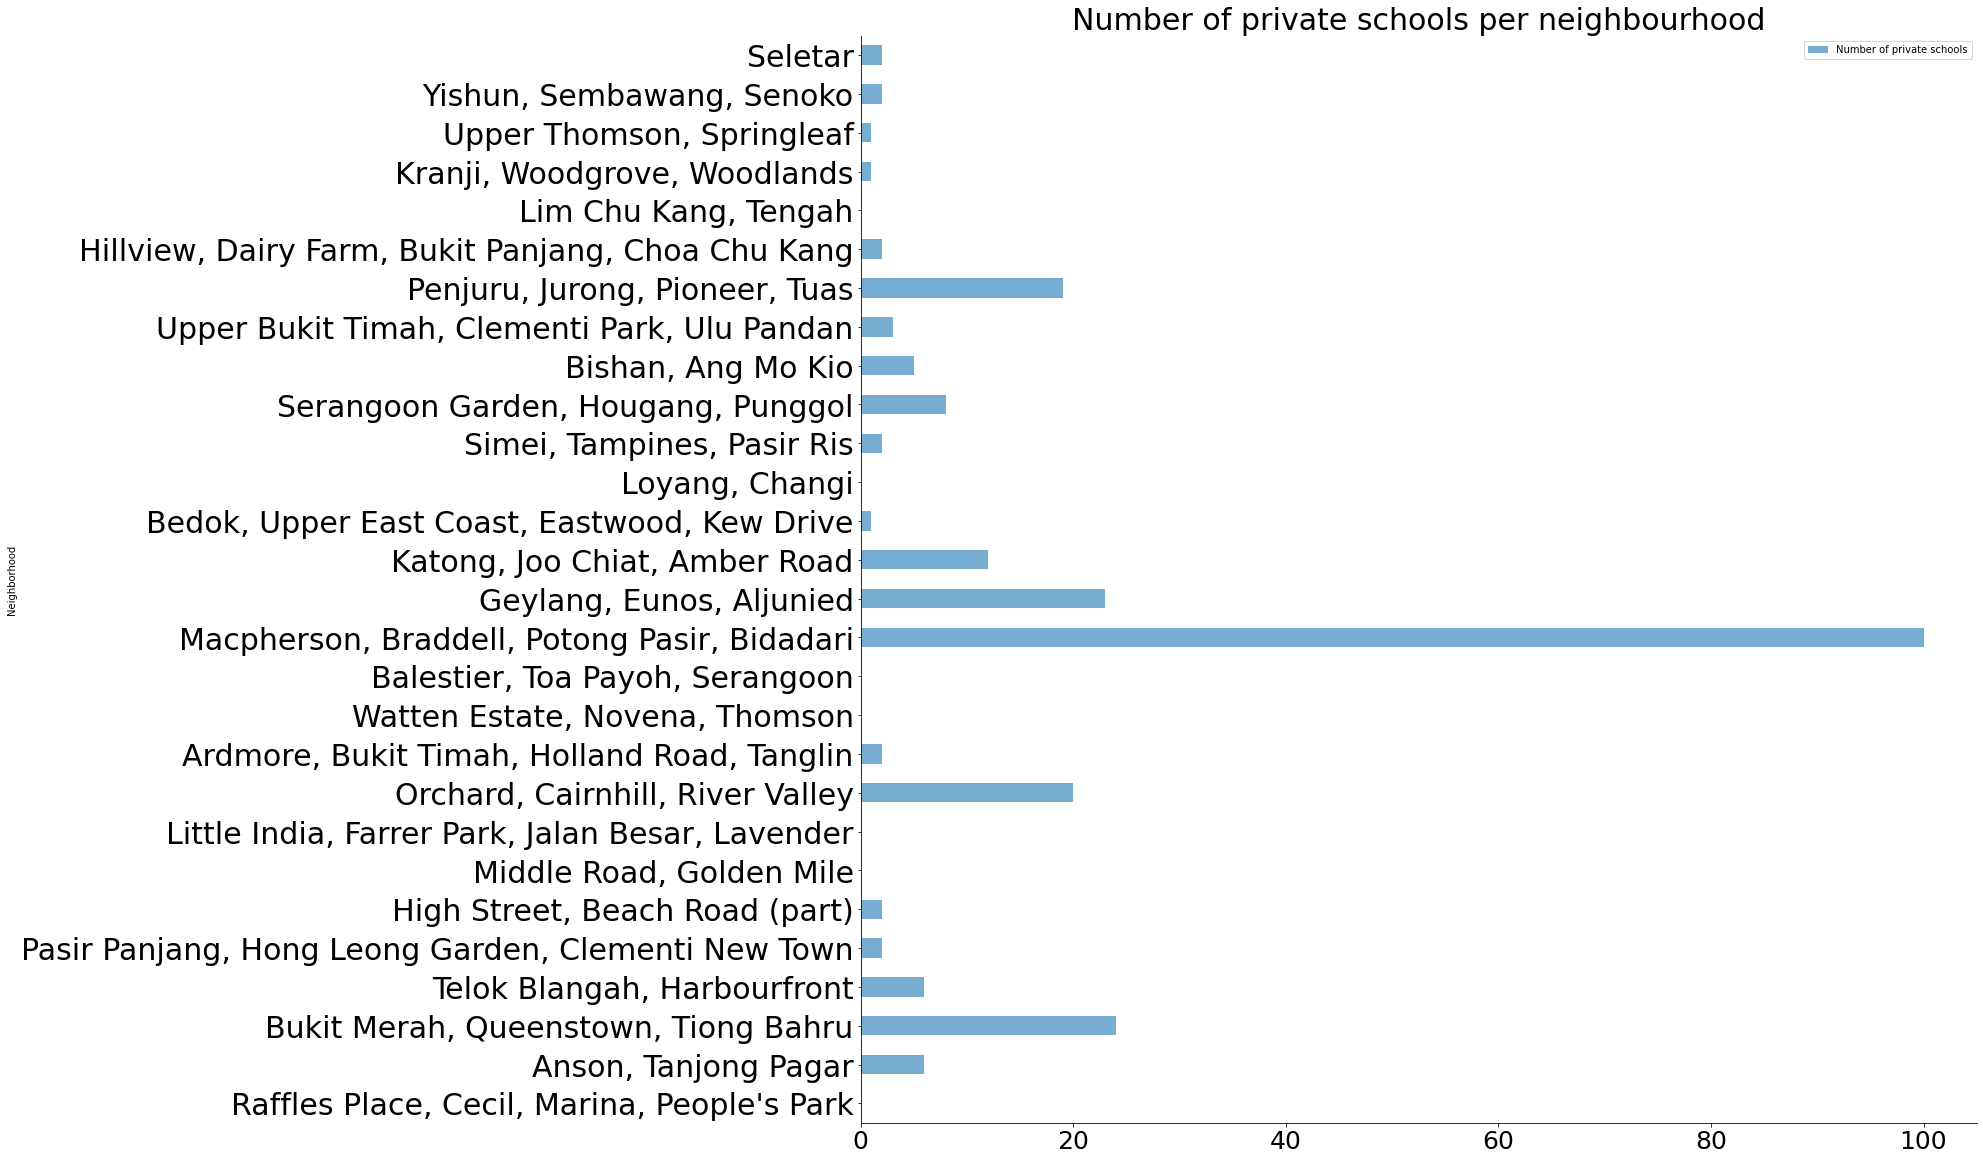

In [46]:
Number_of_privates_schools.plot(kind='barh',figsize=(20,20),alpha=0.6)
plt.xticks(fontsize= 25)
plt.yticks(fontsize= 30)
plt.title("Number of private schools per neighbourhood", fontsize =30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [91]:
labels = ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
c1 = cluster0['Private schools'].sum()
c2 = cluster1['Private schools'].sum()
c3 = cluster2['Private schools'].sum()
c4 = cluster3['Private schools'].sum()
nb = [c1, c2, c3, c4]

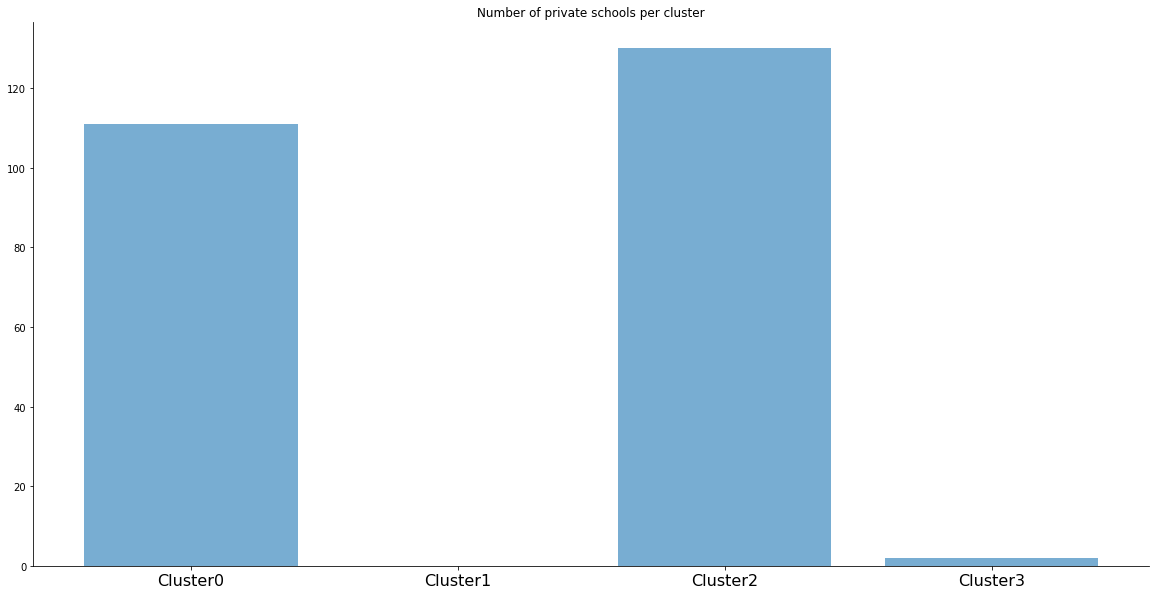

In [92]:
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x, nb, width = 0.8, alpha = 0.6)
ax.set_xticklabels(labels, fontsize = 16)
ax.set_xticks(x)
ax.set_title('Number of private schools per cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Average housing sales prices per cluster

In [104]:
Average_housing_sales_prices = pd.DataFrame({"Neighborhood":sg_data["General location"], "Average sales prices": sg_data["Price ($)"]})
Average_housing_sales_prices.set_index('Neighborhood',inplace=True,drop=True)
Average_housing_sales_prices = Average_housing_sales_prices.dropna()

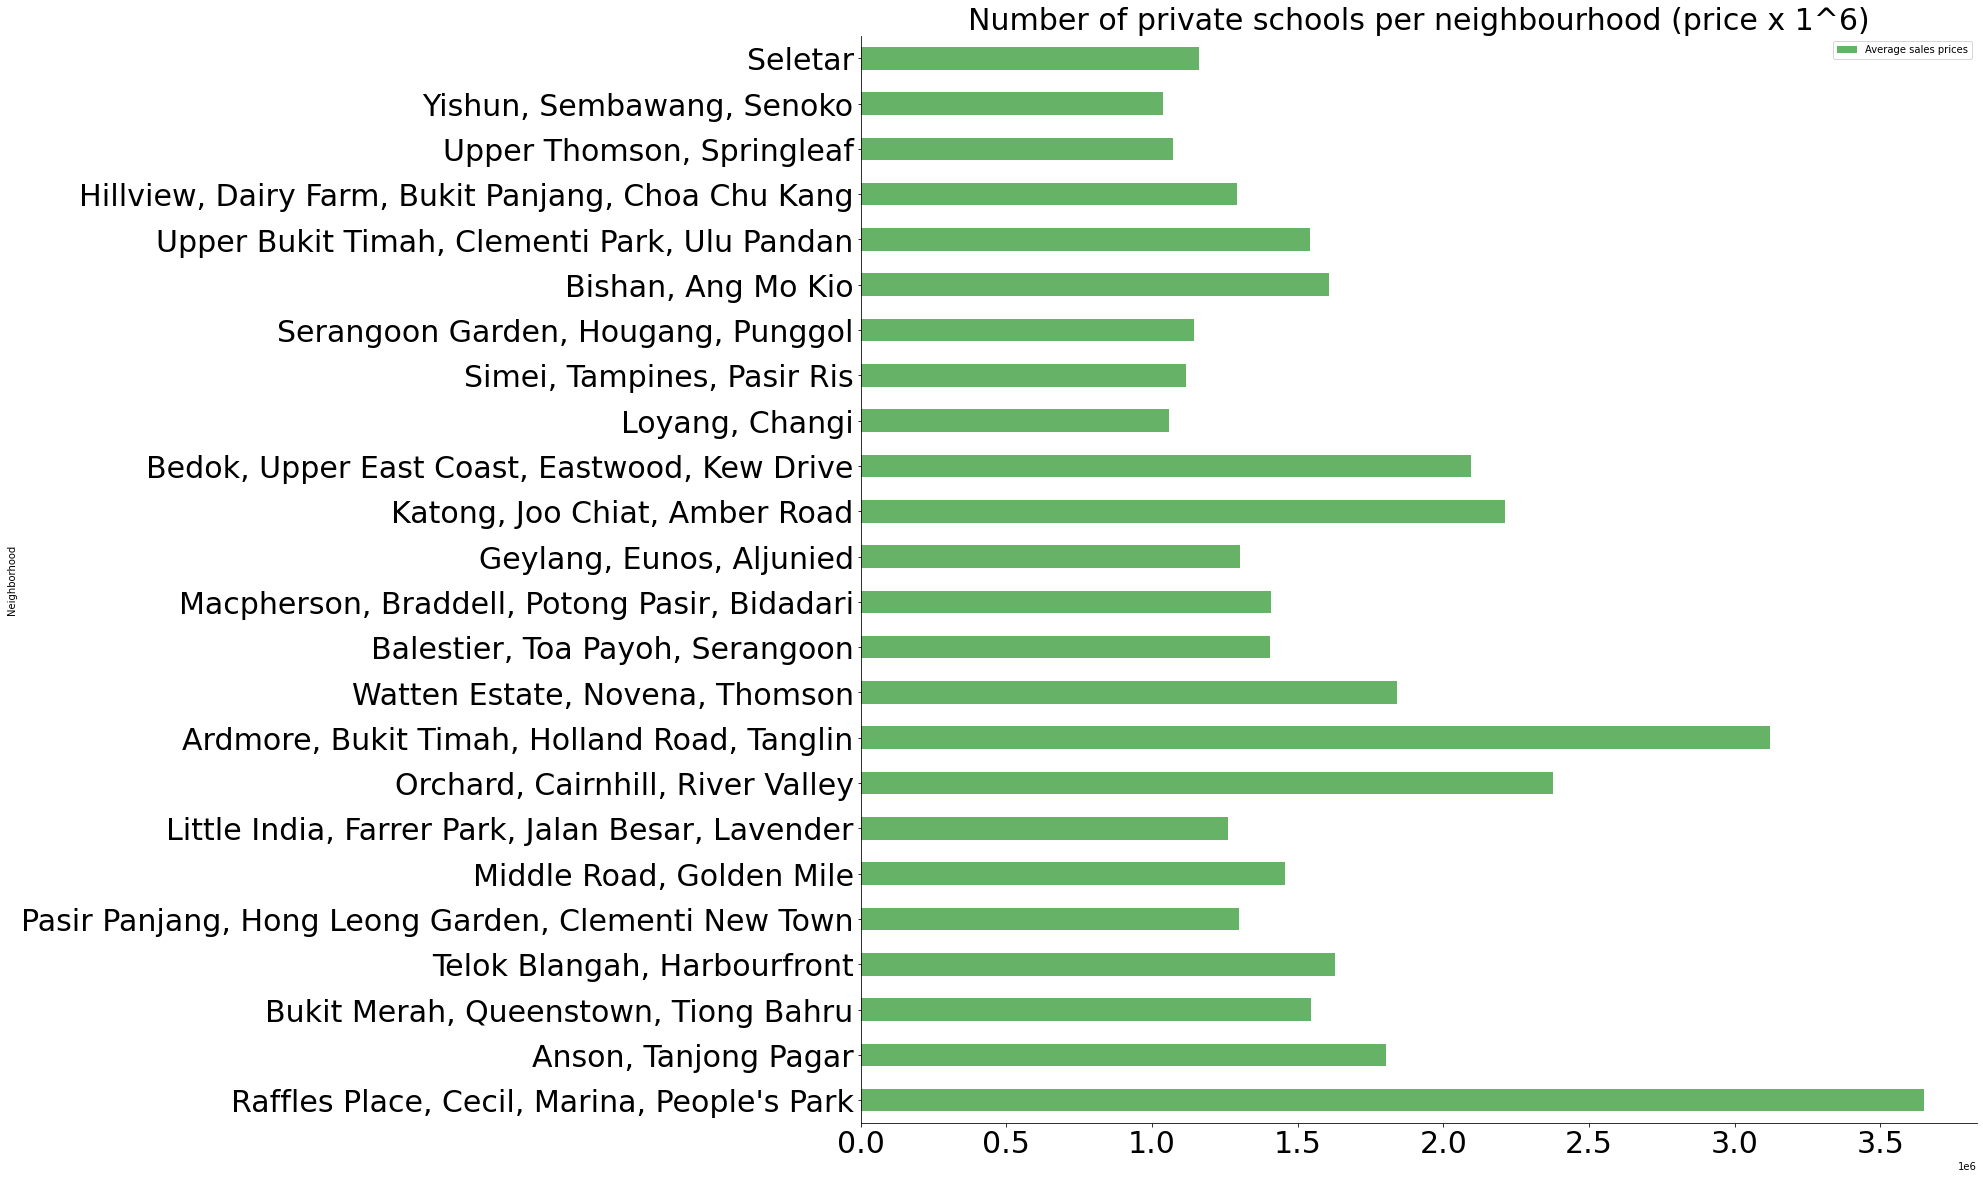

In [105]:
Average_housing_sales_prices.plot(kind = 'barh',figsize = (20,20), alpha = 0.6, color = 'green')
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.title("Number of private schools per neighbourhood (price x 1^6)", fontsize =30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [121]:
Labels = ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
C1 = cluster0['Price ($)'].dropna().mean()
C2 = cluster1['Price ($)'].dropna().mean()
C3 = cluster2['Price ($)'].dropna().mean()
C4 = cluster3['Price ($)'].dropna().mean()
NB = [C1, C2, C3, C4]

[111.0, 0.0, 130.0, 2.0]

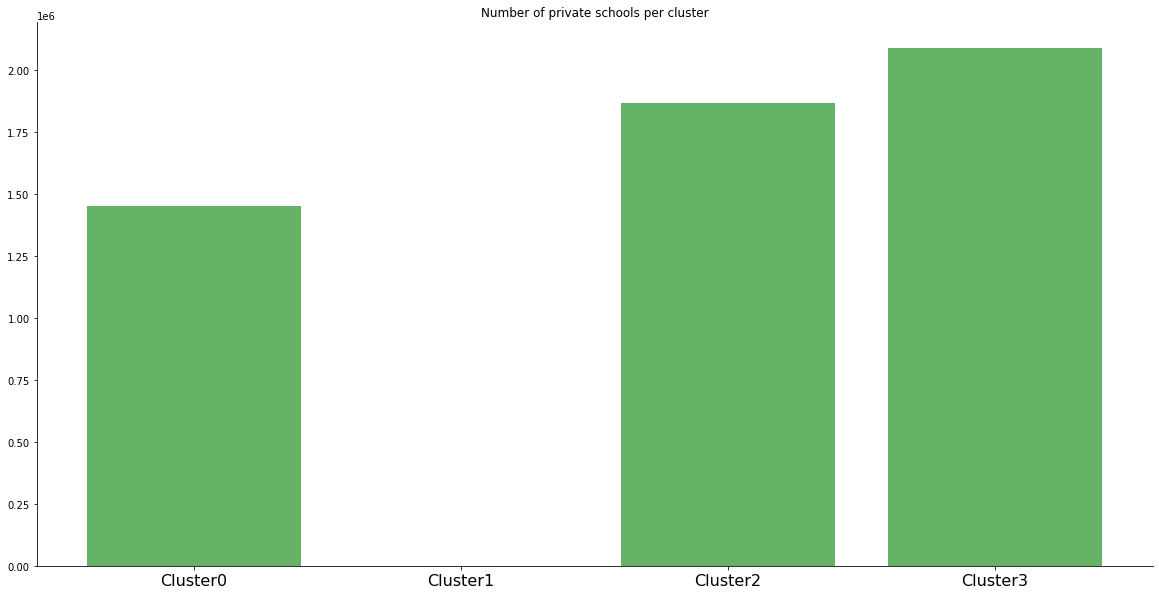

In [120]:
X = np.arange(len(Labels))  # the label locations

fig, ax = plt.subplots(figsize=(20,10))
rects2 = ax.bar(X, NB, width = 0.8, alpha = 0.6, color = 'green')
ax.set_xticklabels(Labels, fontsize = 16)
ax.set_xticks(X)
ax.set_title('Number of private schools per cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Results and Discussion <a name="results"></a>

Based on the clustering model and on the different data studied. It seems that clusters 0 and 2 are the most attractive one to explore or move into. With most of the private schools and average sales prices lower than cluster 3, they seem to be the clusters that have the most to offer. Nevertheless Cluster 2 presents most of the hotels and the airport, it might be a more touristic area. Cluster 0 might be the most appropriate to move into.



## Conclusion <a name="conclusion"></a>

In this we have gone through the process of identifying a business problem, gathered the required data, extracting and preparing it. Visualizing the result and performing a machine learning algorithm by clustering the data into 4 clusters in order to reach a solution to the business problem.
This project also provides recommendations to visitors, potential immigrants and investors. However, there are clear limitations to this project and all the assumptions made. Notably because of the data gathered. Foursquare is a great source of information for general venues. There are other possible factors to account for like, income of the residents residing, rental rates, essential infrastructures (Pharmacy, Bank, Police station, etc.) and many more. Lastly, the assumption was made by taking the 100 venues within a 1 km radius only. 
